# 090 Face Verification Assignment

> COM6018

*Copyright &copy; 2024 Jon Barker, University of Sheffield. All rights reserved*.


## 1. Introduction

This notebook have been written to accompany the Face Verification assignment. The notebook is unlike the previous labs notebooks, in that it is not a step-by-step guide to a solution. Instead, it contains some notes and snippets of code that you may find useful.


## 2. Understanding the data provided

The assignment makes use of a number of data files that you will need to download from the following location:

https://drive.google.com/drive/folders/10y3e2zKkh0lVpRZ3WC21Uu-v-EcbBSYs?usp=sharing

As described in the assignment handout, you are provided with the following files:

- `train.joblib` - the full training dataset
- `eval1.joblib` - a dataset for evaluating your model
- `baseline_model.joblib` - pre-trained kNN models, i.e., a baseline solution

If you have not downloaded these already, do so now and store them in the same directory as this notebook.

### 2.1 The training data

We will first look at the training data. The data can be loaded using the `joblib` library. The training data is stored as a tuple with two elements: a NumPy array of face images and a NumPy array of labels. The code below loads the data. It is also printing out the shape of the arrays to confirm that it has loaded correctly.


In [6]:
import joblib
data_train = joblib.load('train.joblib')
print(data_train.keys())
print(data_train['data'].shape)
print(data_train['target'].shape)


dict_keys(['data', 'target'])
(2200, 5828)
(2200,)


Note, the shape of the train data array is (2200, 5828). This means it is a 2-D array storing 2200 samples, each of which is have 5828 features. These features represent the pixel values for a pair of face images that have been unwrapped into a row of the array. We can extract a single image using `one_image = data_train['data'][n]` where n is the index of the sample. 

The code below extracts the $n$th image and displays it along with the corresponding person ID.

In [9]:
import matplotlib.pyplot as plt
n = 200
sample = data_train['data'][n]
print(sample.shape)

(5828,)


To view this as a pair of images we need to reshape it back in a 3D array of shape (2, n_pixels_y, n_pixels_x). The code below does this and then displays the pair of images. The images have a shape of 62 rows (y) by 47 colums (x), so the code to do this looks like below.

In [13]:
images = sample.reshape((2, 62, 47))
print(images.shape)


(2, 62, 47)


We can now display the pair of images side by side using Matplotlib's subplot and imshow, as follows

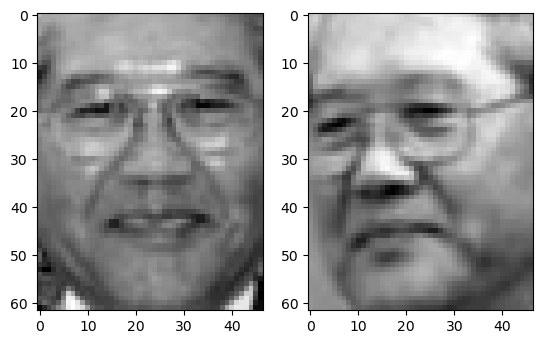

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(images[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(images[1], cmap='gray')
plt.show()

Above, we reshape a single image into a 3D array. It is actually more convenient to reshape the entire dataset into a 4D array, i.e. (n_samples, 2, n_pixels_y, n_pixels_x). We can then store this back in the data dictionary using a new key, 'images'. The code below does this.

In [14]:
data_train['images'] = data_train['data'].reshape((2200, 2, 62, 47))

We can now write a function to display the nth sample of the data along with the target value.

In [25]:
def display_data(data, n):
    """Display a sample of the data as two images and their label."""
    images = data['images'][n]
    plt.subplot(1, 2, 1)
    plt.imshow(images[0], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(images[1], cmap='gray')
    plt.show()
    if data['target'][n] == 0:
        print('The images are from different persons.')
    else:
        print('The images are from the same person.')

We test the function below. Try calling it with different values for the index.

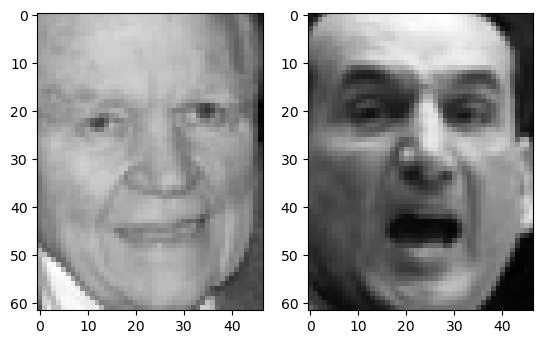

The images are from the same person.


In [24]:
display_data(data_train, 1200)

## 2.2 The evaluation data

The evaluation data is stored in exactly the same format at the training data. The only difference is that there are only 1000 samples rather than 2200. So the data is stored in a 2D array of shape (1000, 5828). 

The code below loads the data, adds the 'images' key and uses the function we've written to look at the first sample.


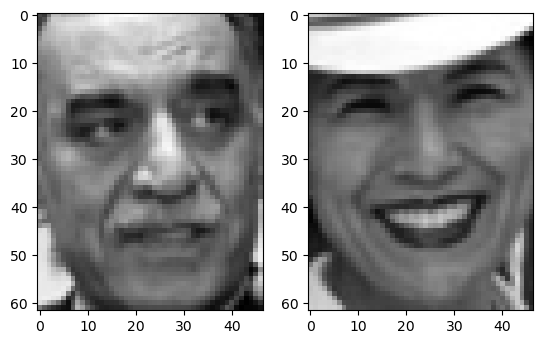

The images are from different persons.


In [26]:
data_eval = joblib.load('eval1.joblib')
data_eval['images'] = data_eval['data'].reshape((1000, 2, 62, 47))

display_data(data_eval, 800)


## 2.3 The baseline model

A baseline model has been trained for you and stored in the files `baseline_model.joblib`. This can be loaded using the `joblib` library. The code below loads model.


In [27]:
import joblib

model = joblib.load('baseline_model.joblib')

print(model)


Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=1))])


Note above that the print statement provides a description of the model. You can see that it is Pipeline with a single step, the KNN Classifier, constructed with $k=1$. The performance of this model is not great and it should be easy for you to improve on it.

We can check the performance by using the model's score method and passing the evaluation data as follows,

In [28]:
percent_correct = model.score(data_eval['data'], data_eval['target']) * 100 
print(f'The classifier is {percent_correct:.2f}% correct')

The classifier is 56.30% correct


You should get a score of 56.3%. This is significantly above chance (50%) but there is plenty of room for improvement.

Or is we want to look in more detail, we can compute and display a confusion matrix. There are only two classes ('different' or 'the same') so the matrix will be  just 2 by 2. Read and then the code below,

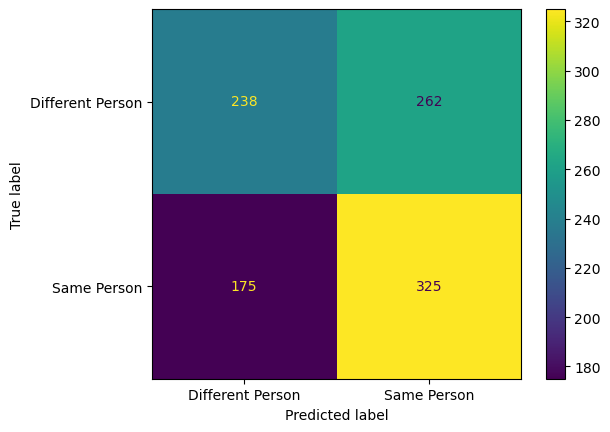

In [34]:
# dispaly the confusion matrix using sklearn's display function

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(data_eval['data'])
cm = confusion_matrix(data_eval['target'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Different Person', 'Same Person'])
disp.plot()




Study the above confusion matrix carefully and make sure that you under the meaning of each entry. What do you notice about the sum of the rows? What does this tell you? What do you notice about the sum of the columns? What does this tell you?

## Measuring Human Performance

For tasks like this, it is interesting to be able to compare the model performance against Human ability. 

I have provided a simple annotation tool in a file called `tools.py`. Make sure that you have a copy of this file and that it is stored in the same directory as this notebook. 

The tool will display images from the evaluation set and provide you with a set of buttons that you can use to decide the orientation of the face. The tool will then display the next image. The tool will continue until you choose the 'QUIT' button. The results of your experiment will be saved in a csv file.

The tool uses some external dependency that you may need to install using `pip`. This can be done by running the cell below

In [39]:
!pip install jupyter_ui_poll ipywidgets

Before running the tool, we first need to make an empty csv file that will be used for saving the results. We will call this file `human.csv`. Run the cell below to perform this step.


In [40]:
results_file = 'human.csv'
with open(results_file, 'w') as f:
    f.write("n_pixels, index, direction, label\n")

We can now run the annotation tool. We will start by using the 90 pixel sub-images. Run the code below and label about 50 images before hitting 'QUIT'.

(5828,)


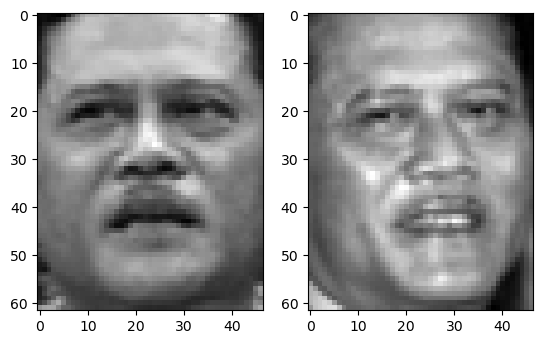

Completed 3


In [ ]:
import tools
import joblib
import importlib
importlib.reload(tools)
data_eval = joblib.load('eval1.joblib')

tools.annotate(data_eval['data'], data_eval['target'], results_file)

A file called 'human.csv' should have appeared in the folder where you are storing the notebook. Have a look at the contents of the folder in an editor. It will show you the label that you selected and the correct label. You can use this to calculate the accuracy of your annotations.


## 3. Runnning Python script from the command line

So far in this module we have been running all our Python code from inside a Jupyter notebook. Jupyter notebooks are very convenient for rapid prototyping, experimentation and demonstrating ideas, but they are less good for training and evaluating models in a reproducible way. For this, it is better to use a Python script that can be run from the command line. This is what you will need to do for the assignment.

The code below shows a Python script that loads a model and evaluates it with the evaluation data. Cut and paste the code below and save it in a file called `my)evaluate.py`. Then open a command line window and run the script using the command `python my_evaluate.py`. You should see the same accuracy as you saw when you ran the code in the notebook.

(Note, if the code does not work, you may need to install the `joblib` library using `pip`, i.e., run `pip install joblib`).

In [ ]:
"""Python script for evaluating a model

Cut and paste this code into a file called `evaluate.py` and run it with the command `python evaluate.py`.
"""
import joblib

def main():
    """Function to evaluate the model."""

    # Load the model for 50 pixel sub-images
    model = joblib.load('baseline_model.joblib')

    # Load the evaluation data 
    data = joblib.load('eval1.joblib')

    # Evaluate the model and print the results
    percent_correct = model.score(data['data'], data['target']) * 100
    print(f'The classifier is {percent_correct:.2f}% correct')


if __name__ == "__main__":
    main()


The code above should all be very familiar to you from the code we have seen in the notebooks. Notice how all the code that you want to run appears inside a function called `main`. This is good practice and avoids having variables defined in the global scope. This top level function can be called anything, but it is conventional to call it `main`. 

Notice how the call to the function `main` occurs at the bottom of the script and is inside an if-statement. This line "if __name__ == '__main__':" is a common pattern using a special variable "__name__" that is automatically set to "__main__" when the script is run from the command line. So this pattern ensures that the code only runs when it is called from the command line. This is useful because it means you can import this code into another script without it running automatically. Do not worry about this too much, but it is good practice to use this pattern.

The code above is not very versatile because it always uses the same model file. It would be better if we could pass these as command line arguments. Python has a module called `argparse` that makes this easy. The code below shows how to use this module to pass the model file and the evaluation data as command line arguments. Cut and paste the code below and save it in a file called `my_evaluate2.py`. Then open a command line window and run the script using the command `python my_evaluate2.py baseline_model.joblib eval1.joblib`. You should see the same accuracy as you saw when you ran the code in the notebook.

In [ ]:
"""Evaluate a given model using a given dataset.

Usage:
    python evaluate_model.py <model_file> <eval_data>

    model_file: The name of the model file.
    eval_data: The name of the eval data file.
"""

from argparse import ArgumentParser
from joblib import load


def evaluate(model_file, eval_data):
    """Evaluate a model on the eval1 dataset.

    Args:
        model_file (str): The name of the model file.
        eval_data (str): The name of the eval data file.
    """

    print(f"Evaluating {model_file} with {eval_data}")

    model = load(model_file)
    data = load(open(eval_data, "rb"))

    score = model.score(data["data"], data["target"])
    return score


def main():
    """Evaluate a model using a given dataset."""

    # Parse the command-line arguments
    parser = ArgumentParser()
    parser.add_argument("model_file", type=str)
    parser.add_argument("eval_data", type=str)
    args = parser.parse_args()

    # Evaluate the model
    score = evaluate(args.model_file, args.eval_data)
    print("Score:", score * 100, "%")


if __name__ == "__main__":
    main()


With your new version of the script you can now also evaluate the other models and the other sub-image sizes. For example, to evaluate the 30 pixel model, you would run the command `python my_evaluate2.py baseline_model.joblib eval1.joblib`. 

If you'd trained your own model you could now use the same script. For example, if you'd trained a model called `my_model.joblib` you could evaluate it using the command `python my_evaluate2.py my_model.joblib eval1.joblib`.

Note in the code above that the `main` method handles the parsing of the commandline arguments and then calls a function called `evaluate` to do the useful work. It is good practice to separate the argument parsing from the rest of the code functionality. This makes the code easier to read and understand. It also means that the code can be re-used in other scripts. For example, we may have another script that has its own commandline parsing but which wants to use the evaluate function. This can be easily done by importing the `my_evaluate2.py` script, e.g. with `import evaluate from my_evaluate2`. This would not be possible is the commandline parsing and evaluate code were all mixed together in the `main` function.

The `argparse` module is very sophisticated and can handle many different types of commandline arguments. For example, it can handle optional arguments, positional arguments, and arguments with default values. It can also handle arguments that are lists of values. It is easy to learn to use as it has a very good [documentation page](https://docs.python.org/3/library/argparse.html) and there are many examples on the web. The following website has some nicely organised examples that start with simple cases and then build up to more complex usage: https://vnetman.github.io/argparse-recipes/2018/04/21/python-3-argparse-recipe-book.html

## 4. Using Latex

For your final report you have been asked to use LaTeX. LaTeX is a typesetting system that is widely used in academia. It is very good for writing technical documents that contain equations and figures. It is also very good for writing documents that contain references to other documents. You will need to use it for your dissertation, so this is a good opportunity to learn how to use it.

We will discuss this more in the lecture session on Monday.

LaTeX can be installed on your own computer, or it can also be used online via the website https://www.overleaf.com/. Overleaf is an excellent LaTeX hosting service that has a lot of documentation and examples. It is free to use, but you will need to create an account. Whether you prefer to use Overleaf or install LaTeX on your own computer is up to you. The advantage of running on your own computer is that you can work offline and it can be faster. The advantage of Overleaf is that it is easier to get started and you can work on your report from any computer with an internet connection.

## 4.1 Installing LaTeX on your own computer

If you want to install LaTeX on your own computer, you can download it from the following website: https://www.latex-project.org/get/. Installation should be very easy for Linux and Mac. LaTeX is also available for Windows, but it is a bit more complicated to install. If you are using Windows, I recommend that you use Overleaf instead.

There is a template for the assignment stored in a zip file called 'COM6018_latex_template.v1_0.zip' in the assignment directory of the module's git repository. Run 'git pull' to make sure that you have it and then copy it to a new working directory and unzip it. Move into the folder 'COM6018_latex_template'. If you have LaTeX installed correctly then you should be able to compile the template document using the command 'pdflatex report.tex'. This should create a file called 'report.pdf' that you can open in a PDF viewer. If you have any problems, please ask for help or use Overleaf instead (next section)

## 4.2 Using LaTeX online with Overleaf

Overleaf is one of several online LaTeX services, others include Papeeria, LaTeX base, CoCalc. Overleaf is the most popular and has the best documentation and examples. It is free to use, but you will need to create an account.

To get started with Overleaf, go to the website https://www.overleaf.com/ and create an account. Then click on the 'New Project' button and select 'Upload Project'. Then upload the file `COM6018_latex_template.zip` that you can find in the assignment directory of the module's git repository.

After uploading the zip file, the project should open and you will see the LaTeX source on the left and the pdf document that it generates on the right. You can edit the source and the pdf will automatically update. 

We will spend time on Monday explaining how to use LaTeX. In the meantime, you can look at the source of the template document and try to work out what it is doing. You can also look at the Overleaf documentation and examples. The following page is a good place to start: https://www.overleaf.com/learn/latex/Learn_LaTeX_in_30_minutes





*Copyright &copy; 2023, 2024 Jon Barker, University of Sheffield. All rights reserved*.